In [1]:
clean_up=True # removes gams-related files in work-folder if true
%run StdPackages.ipynb
os.chdir(py['main'])
import Government
from DataBase_wheels import small_updates
os.chdir(curr)
data_folder = os.getcwd()+'\\Data\\IO'
gams_folder = os.getcwd()+'\\gamsmodels\\G'

The government sector defines the tax rates that goes into other modules. In the simplest case, we assume that taxation are in constant rates (from the perspective of the firms/consumers). This entails that three tax rates should be supplied by the government sector module:
* $tauD[t,s,n]$: The tax rate levied in the use of inputs such that $PwT[t,s,n] = Peq[t,n]+tauD[t,s,n]$ where $PwT$ is the price with taxes for sectors $s$, good $n$. The revenue from this tax is thus defined as $\sum_{(s,n)\in d\_tauD[s,n]} qD[t,s,n]*tauD[t,s,n]$.
* $tauS[t,s,n]$: The tax rate levied on the output of a sector. This defines the difference between prices before taxes and equilibrium taxes (some variations in how they are specifically used in modules). The revenue from this tax is defined as $\sum_{(s,n)\in d\_tauS[s,n]} qS[t,s,n] * tauS[t,s,n]$.
* $tauLump[t,s]$ for $s\in s\_HH$: The lump sum tax that is charged on households. For other sectors (production, investment), the lump-sum tax is computed as a part of the $tauS[t,s,n]$ tax on the sectors' outputs.

Note that this restricts us to only charge constant rates for supply/demand of any type, i.e. the marginal tax rate = average tax rate. However, nothing prevents us from creating more elaborate functions for how these prices may evolve (as functions e.g. of quantity variables). 

### *A simple setup for tax rates:*

In the following we define a simple government sector with the following instruments:
* $tauLump[t,s]$: A lump-sum tax is levied on all sectors except (1) trade and (2) inventory investment sectors.
* $tauS[t,s,n]$: A flat rate charged on the supply of goods.
* $tauD[t,s,n]$: A flat rate charged on the demand of goods.

### *1: Read in data*

*Load IO data:*

In [2]:
GE_data = DataBase.GPM_database(pickle_path=data_folder+'\\GE_data')

*Load global settings:*

In [3]:
with open(data_folder+'\\Ex1_gs',"rb") as file:
    gs = pickle.load(file)

*settings:*

In [4]:
name_module = 'G'

### *2: Static model:*

In [5]:
gm_static = Government.g_static(GE_data=GE_data.copy(),work_folder=work_folder,**{'data_folder':gams_folder,'name':'g_static'})

Run simple baseline model:

In [6]:
gm_static.write_and_run(kwargs_init={'check_variables':True},overwrite=True)

*Calibrate:*

In [7]:
gm_static.setstate('SC')
gm_static.reset_settings() # this resets the RunFile and CollectFile settings.
gm_static.write_and_run(overwrite=True) # this overwrites files in the work_folder if they already exists.
db_static = gm_static.model_instances['baseline'].out_db

### *3: Dynamic model:*

In [8]:
gm_G = Government.g_dynamic(GE_data=GE_data.copy(),work_folder=work_folder,gs_v = gs,**{'data_folder':gams_folder,'name':name_module})
gm_G.ivfs(db_static,merge=False)
gm_G.initialize_variables(**{'check_variables': True})

In [9]:
GE_G = small_updates.subset_db(GE_data.copy(),gm_G.get('s_G'))
GE_G_t = DataBase.GPM_database()
for var in GE_G.variables_flat:
    GE_G_t[var] = DataBase_wheels.repeat_variable_windex(GE_G.get(var),gm_G.get('t0'))
gm_G.setstate('DC')
GE_G_t = gm_G.slice_exo(GE_G_t,copy=False)
gm_G.calibrate_sneaky(GE_G_t,overwrite=True,**{'n_steps':2,'diff':True})

{'Modelstat': 15.0, 'Solvestat': 1.0}

*Store as pickle to run from at a later point:*

In [10]:
db = gm_G.model_instances['baseline'].out_db 
[db.series.__delitem__(sym) for sym in db.symbols if sym not in gm_G.model.database.symbols];
gm_G.model.database.merge_dbs(gm_G.model.database,db,'second')
gm_G.export()

'C:\\Users\\sxj477\\Documents\\GitHub\\GPM_v05\\examples\\gamsmodels\\G\\gmspython_G'

*inspect solution:*

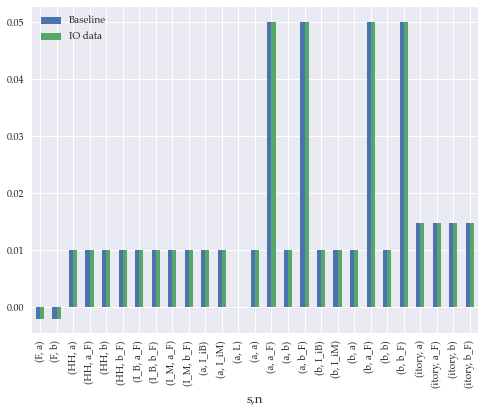

In [11]:
compare_vars,year = 'tauD',1
ci = DataBase.gpy_symbol(db[compare_vars].rctree_pd(GE_data[compare_vars]).xs(year))
pd.DataFrame({'Baseline': db[compare_vars].rctree_pd(ci).xs(year), 'IO data': GE_data[compare_vars].rctree_pd(ci)}).plot.bar(figsize=(8,6));